In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy import stats
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import seaborn as sns
import statsmodels.api as sm
import itertools

In [4]:
def load_peace_sys_data():
    df = pd.DataFrame(pd.read_csv('peace_sys.csv', index_col=0, na_values=['(NA)']))
    return df

In [5]:
def get_odds_ratios(coefs):
    return np.exp(coefs[0])


In [6]:
def logit_pvalue(model, x):
    """ Calculate z-scores for scikit-learn LogisticRegression.
    parameters:
        model: fitted sklearn.linear_model.LogisticRegression with intercept and large C
        x:     matrix on which the model was fit
    This function uses asymtptics for maximum likelihood estimates.
    """
    # first index refers to proba that belongs to class 0
    # second index refers to proba that belongs to calss 1
    p = model.predict_proba(x) # return matrix (N,2)
    # number of samples
    n = len(p)
    # number of features + 1 
    m = len(model.coef_[0]) + 1
    coefs = np.concatenate([model.intercept_, model.coef_[0]]) # put intercept and coefs in same array
    x_full = np.matrix(np.insert(np.array(x), 0, 1, axis = 1)) # 
    ans = np.zeros((m, m))
    for i in range(n):
        # dot product of transposed row and row
        # then multiply by both probas
        # add it to ans
        ans = ans + np.dot(np.transpose(x_full[i, :]), x_full[i, :]) * p[i,1] * p[i, 0]
    # acovariance matrix
    vcov = np.linalg.inv(np.matrix(ans))
    # square root diagonal of covariace matrix
    se = np.sqrt(np.diag(vcov))
    # divide coefs by standard error
    t =  coefs/se 
    # two tailed using normal dist
    p = (1 - stats.norm.cdf(abs(t))) * 2
    return p

In [7]:
def logit_with_nan(data):
    data_copy = data.drop('PSys', axis=1)
    pvalues = []
    logit_beta = []
    logit_odds_ratio = []

    
    for label in data_copy.columns:
        X = data[[label, 'PSys']]
        X = X.dropna()
        
        y = X.PSys
        X = X.drop('PSys', axis=1)
        
        logreg = LogisticRegression(random_state=42, C=1e9)
        logreg.fit(X, y)
        pvalue = logit_pvalue(logreg, X)[1]
        
        pvalues.append(pvalue)
        
        beta = np.absolute(logreg.coef_[0][0])
        logit_beta.append(beta)
        logit_odds_ratio.append(np.exp(beta))
        
        
    res = pd.DataFrame({'Variable' : data_copy.columns,
                        'Logistic_Sig_Level' : pvalues,
                        'Logistic_Beta' : logit_beta,
                        'Logistic_Odds_Ratio' : logit_odds_ratio
                       })
    
    res = res.set_index('Variable')
    
    return res

In [8]:
def compute_ttest(peaceful, non_peaceful):
    variables = peaceful.columns
    res_df = pd.DataFrame(columns=['feature', 't_statistic', 'p_value'])
    
    for var in variables:
        x = peaceful[var]
        y = non_peaceful[var]
        ttest = stats.ttest_ind(x, y)
        temp = pd.DataFrame({'feature' : [var] , 
                             't_statistic' : ttest.statistic, 
                             'p_value' : [ttest.pvalue]})
        res_df = res_df.append(temp)
        
    res_df.set_index('feature', inplace=True)
    return res_df

In [9]:
def ttest_with_nan(data):
    """ 
    This is a two sided test for the null hypothesis that 2 independent samples
    have identical average(expected) values.
    
    Test assusmes that the populations have identical variances by default
    
    Parameters
    ----------
    data: DataFrame
        The DataFrame that contains Nan values
        
    Returns
    -------
    returns DataFrame that contains statistic and pvalue for every column in data
    
    t_statistic: float
        Calculated t-statistic
    
    p_value: float
        Two tailed p-value
            
    """
    # create a copy that excludes target variable
    data_copy = data.drop('PSys', axis=1)
    # prepare result data frame
    res_df = pd.DataFrame(columns=['Variable', 't_statistic', 'ttest_p_value'])
    # for every label, we separate each row by what its target value is
    # we drop the nan values
    for label in data_copy.columns:
        X = data[[label, 'PSys']]
        X = X.dropna()
        # filter peaceful 
        peaceful = X[X.PSys == 1]
        peaceful = peaceful.drop('PSys', axis=1)
        
        non_peaceful = X[X.PSys == 2]
        non_peaceful = non_peaceful.drop('PSys', axis=1) 
        # calculate two-sided ttest
        ttest_result = stats.ttest_ind(peaceful, non_peaceful)
        ttest_df = pd.DataFrame({'Variable' : [label],
                                 't_statistic' : ttest_result.statistic,
                                 'ttest_p_value' : ttest_result.pvalue
                                })
        
        res_df = res_df.append(ttest_df)
    
    res_df.set_index('Variable', inplace=True)
    
    return res_df

In [10]:
def compute_mannwhitneyu(peaceful, non_peaceful):
    variables = peaceful.columns
    res_df = pd.DataFrame(columns=['feature', 'statistic', 'p_value'])
    
    for var in variables:
        x = peaceful[var]
        y = non_peaceful[var]
        utest = stats.mannwhitneyu(x, y)
        temp = pd.DataFrame({'feature' : [var] , 
                             'statistic' : utest.statistic, 
                             'p_value' : [utest.pvalue]})
        res_df = res_df.append(temp)
        
    res_df.set_index('feature', inplace=True)
    return res_df

In [11]:
def mannwhitneyu_with_nan(data):
    """ 
    Computes the Mann-Whitney rank test on each of the columns of data
    Each column is seperated into 2 different arrays
    
    One group is peaceful, the other group is non-peaceful
    
    Parameters
    ----------
    data : DataFrame
        DataFrame that contains nan values
        
    Returns:
    -------
    Retures a DataFrame with U_statistic and Pvalue for every column
    
    U_statististic: float
        Mann-Whitney U statistic, equal to min(U for x, and U for y)
        
    p_value: float
        p-value assuming asymptotic normal distribution. Two-Sided.
    """
    data_copy = data.drop('PSys', axis=1)
    res_df = pd.DataFrame(columns=['Variable', 'U_statistic', 'mannwhitneyu_p_value'])
    for label in data_copy.columns:
        # isolate the target variable and current variable
        X = data[[label, 'PSys']]
        # drop all Nan values
        X = X.dropna()
        # filter out peaceful rows
        peaceful = X[X.PSys == 1]
        peaceful = peaceful.drop('PSys', axis=1)
        # filter out non peaceful rows
        non_peaceful = X[X.PSys == 2]
        non_peaceful = non_peaceful.drop('PSys', axis=1) 
        # calculates two-sided Mann-Whitney U test
        utest_result = stats.mannwhitneyu(peaceful, non_peaceful, alternative='two-sided')
        ttest_df = pd.DataFrame({'Variable' : [label],
                                 'U_statistic' : utest_result.statistic,
                                 'mannwhitneyu_p_value' : utest_result.pvalue
                                })
        
        res_df = res_df.append(ttest_df)
    
    res_df.set_index('Variable', inplace=True)
    
    return res_df

In [12]:
peace_sys = load_peace_sys_data()

peace_sys

,SCCS,Coder,ID1.1Over,ID1.2Ethno,Int2.1Mar,Int2.2Econ,Int2.3Pol,Int2.4Hist,Dep3.1Sec,Dep3.2Ecol,...,CM8.5Peace,CM8.6War,Lead9.1P,Lead9.2War,Cult10.1Com,Cult10.2Diff,Comp10.3,InComp10.4,PSys,PSysRec
Name,,,,,,,,,,,,,,,,,,,,,
Gilbertese,107,KA,9.0,2.0,3,9.0,9,9,9,9,...,9,9,9,9,9,9,9,9,2,0
Marshallese,108,EC,1.0,9.0,9,1.0,9,9,9,9,...,9,2,9,4,9,9,9,9,2,0
E. Pomo,135,"KA, EC",9.0,9.0,9,9.0,9,9,1,1,...,9,9,2,9,9,9,9,9,2,0
Popoluca,154,KA,9.0,3.0,9,3.0,9,9,9,3,...,9,9,9,9,9,9,9,9,2,0
Konso,35,KA,9.0,2.0,3,4.0,9,4,9,2,...,9,9,9,9,3,9,3,3,2,0
Bribri,157,DG,9.0,2.0,2,9.0,9,9,9,9,...,9,9,9,9,9,9,9,9,2,0
Tallensi,23,DG,1.0,2.0,4,9.0,1,3,3,9,...,2,9,9,9,4,1,3,9,2,0
Russians,54,DG,4.0,9.0,1,9.0,9,9,9,9,...,2,1,1,9,2,9,9,9,2,0
Trukese,109,DG,3.0,9.0,4,4.0,3,9,3,9,...,9,9,9,9,9,9,9,9,2,0


In [13]:
peace_sys = peace_sys.replace(9, np.nan)

In [14]:
peace_sys = peace_sys.drop(['SCCS','Coder'], axis=1)

In [15]:
NON_WAR_VARS = ['SymP6', 'NWNorm5.1', 'RitP6', 'Dep3.3Econ', 'Int2.4Hist', 'ID1.1Over', 
                'NWVal4.1', 'Int2.2Econ', 'Dep3.2Ecol', 'CM8.5Peace', 'PSys']

In [16]:
WAR_VARS = ['WNorm5.2', 'Lead9.2War', 'SymWar6', 'RitWar6', 'WVal4.2', 'PSys']

In [17]:
VARS = np.unique(NON_WAR_VARS + WAR_VARS)

In [18]:
VARS = np.roll(VARS, 6) # move PSys to the end of the array

In [19]:
VARS

array(['RitP6', 'RitWar6', 'SymP6', 'SymWar6', 'WNorm5.2', 'WVal4.2',
       'CM8.5Peace', 'Dep3.2Ecol', 'Dep3.3Econ', 'ID1.1Over',
       'Int2.2Econ', 'Int2.4Hist', 'Lead9.2War', 'NWNorm5.1', 'NWVal4.1',
       'PSys'], dtype='<U10')

In [20]:
X = peace_sys[VARS].drop('PSys', axis=1)
X = X.fillna(X.mean())

In [21]:
y = peace_sys.PSys
y = y.replace(2, 0)

# Logistic Regression

In [22]:
logit_results = logit_with_nan(peace_sys[VARS])

In [23]:
logit_results

,Logistic_Sig_Level,Logistic_Beta,Logistic_Odds_Ratio
Variable,,,
RitP6,0.013339,2.071619,7.937661
RitWar6,0.010238,1.619016,5.048121
SymP6,0.036682,2.573926,13.117217
SymWar6,0.040487,1.575338,4.832373
WNorm5.2,0.005159,1.323790,3.757636
WVal4.2,0.003350,1.668282,5.303049
CM8.5Peace,0.932156,8.542179,5126.503390
Dep3.2Ecol,0.031614,0.933155,2.542519
Dep3.3Econ,0.010404,1.845498,6.331255


# T-Test

In [24]:
ttest = ttest_with_nan(peace_sys[VARS])

In [25]:
ttest

,t_statistic,ttest_p_value
Variable,,
RitP6,3.893138,0.000839
RitWar6,-3.871833,0.000949
SymP6,3.926992,0.002364
SymWar6,-2.600997,0.018061
WNorm5.2,-3.758143,0.000768
WVal4.2,-4.723962,0.000039
CM8.5Peace,4.147288,0.003221
Dep3.2Ecol,2.502553,0.020254
Dep3.3Econ,4.070873,0.000367


# Mann-Whitney U-Test

In [26]:
mannwhitneyu = mannwhitneyu_with_nan(peace_sys[VARS])

In [27]:
mannwhitneyu

,U_statistic,mannwhitneyu_p_value
Variable,,
RitP6,115.5,0.001604
RitWar6,15.5,0.003076
SymP6,38.0,0.010393
SymWar6,21.0,0.033359
WNorm5.2,43.0,0.001794
WVal4.2,58.5,0.000786
CM8.5Peace,20.0,0.018906
Dep3.2Ecol,109.0,0.026365
Dep3.3Econ,174.0,0.001851


#  Random Forest

In [28]:
rfc = RandomForestClassifier(random_state=42, n_estimators=2000).fit(X, y)

In [29]:
rfc_feature_importances = pd.DataFrame({'Variables' : X.columns, 'rfc_feature_importance' : rfc.feature_importances_})
rfc_feature_importances = rfc_feature_importances.set_index('Variables')

In [30]:
rfc_feature_importances

,rfc_feature_importance
Variables,
RitP6,0.104735
RitWar6,0.031976
SymP6,0.039809
SymWar6,0.017110
WNorm5.2,0.095222
WVal4.2,0.089838
CM8.5Peace,0.040647
Dep3.2Ecol,0.045090
Dep3.3Econ,0.084430


# Putting Everything Together

In [31]:
all_methods = pd.DataFrame({
    'Random_Forest': rfc_feature_importances['rfc_feature_importance'],
    'MannWhitneyU_Test' : mannwhitneyu['mannwhitneyu_p_value'],
    'T_Test' : ttest['ttest_p_value'],
    'Logistic_Regression' : logit_results['Logistic_Sig_Level'],
    'Log_Random_Forest' : ((rfc_feature_importances['rfc_feature_importance'])/(rfc_feature_importances['rfc_feature_importance'].mean())) * np.log10(1/0.05),
    'Log_MannWhitneyU_Test' : np.log10(1 / (mannwhitneyu['mannwhitneyu_p_value'])),
    'Log_T_Test' : np.log10(1 / ttest['ttest_p_value']),
    'Log_Logistic_Regression' : np.log10(1 / (logit_results['Logistic_Sig_Level']))
},)

In [32]:
all_methods

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression
RitP6,0.104735,0.001604,0.000839,0.013339,2.043946,2.794871,3.076473,1.874887
RitWar6,0.031976,0.003076,0.000949,0.010238,0.624017,2.512084,3.022634,1.989787
SymP6,0.039809,0.010393,0.002364,0.036682,0.776889,1.983275,2.626305,1.435552
SymWar6,0.017110,0.033359,0.018061,0.040487,0.333903,1.476788,1.743247,1.392684
WNorm5.2,0.095222,0.001794,0.000768,0.005159,1.858305,2.746260,3.114490,2.287410
WVal4.2,0.089838,0.000786,0.000039,0.003350,1.753224,3.104458,4.408389,2.474977
CM8.5Peace,0.040647,0.018906,0.003221,0.932156,0.793237,1.723404,2.492016,0.030511
Dep3.2Ecol,0.045090,0.026365,0.020254,0.031614,0.879961,1.578967,1.693492,1.500120
Dep3.3Econ,0.084430,0.001851,0.000367,0.010404,1.647688,2.732652,3.435554,1.982779
ID1.1Over,0.060565,0.003749,0.001835,0.007980,1.181946,2.426111,2.736469,2.097977


In [33]:
log_columns = ['Log_Logistic_Regression',  
                                     'Log_T_Test', 
                                     'Log_MannWhitneyU_Test', 
                                     'Log_Random_Forest']

In [34]:
all_methods['LOG_SUM'] = all_methods[log_columns].sum(axis=1)

In [35]:
all_methods['LOG_PRODUCT'] = all_methods[log_columns].product(axis=1)

In [36]:
all_methods

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
RitP6,0.104735,0.001604,0.000839,0.013339,2.043946,2.794871,3.076473,1.874887,9.790177,32.950301
RitWar6,0.031976,0.003076,0.000949,0.010238,0.624017,2.512084,3.022634,1.989787,8.148522,9.428070
SymP6,0.039809,0.010393,0.002364,0.036682,0.776889,1.983275,2.626305,1.435552,6.822021,5.809063
SymWar6,0.017110,0.033359,0.018061,0.040487,0.333903,1.476788,1.743247,1.392684,4.946623,1.197155
WNorm5.2,0.095222,0.001794,0.000768,0.005159,1.858305,2.746260,3.114490,2.287410,10.006466,36.357141
WVal4.2,0.089838,0.000786,0.000039,0.003350,1.753224,3.104458,4.408389,2.474977,11.741047,59.384637
CM8.5Peace,0.040647,0.018906,0.003221,0.932156,0.793237,1.723404,2.492016,0.030511,5.039168,0.103945
Dep3.2Ecol,0.045090,0.026365,0.020254,0.031614,0.879961,1.578967,1.693492,1.500120,5.652540,3.529762
Dep3.3Econ,0.084430,0.001851,0.000367,0.010404,1.647688,2.732652,3.435554,1.982779,9.798673,30.671172
ID1.1Over,0.060565,0.003749,0.001835,0.007980,1.181946,2.426111,2.736469,2.097977,8.442503,16.462643


In [37]:
all_methods['LOG_SUM'][np.argsort(all_methods['LOG_SUM'])][::-1]

NWNorm5.1     13.553849
WVal4.2       11.741047
WNorm5.2      10.006466
Dep3.3Econ     9.798673
RitP6          9.790177
ID1.1Over      8.442503
RitWar6        8.148522
NWVal4.1       8.089120
Int2.4Hist     6.997426
SymP6          6.822021
Int2.2Econ     6.572318
Dep3.2Ecol     5.652540
Lead9.2War     5.621885
CM8.5Peace     5.039168
SymWar6        4.946623
Name: LOG_SUM, dtype: float64

In [38]:
log_product_sorted_indices = np.argsort(all_methods['LOG_PRODUCT'])[::-1]

In [39]:
all_methods['LOG_PRODUCT'][log_product_sorted_indices]

NWNorm5.1     113.929623
WVal4.2        59.384637
WNorm5.2       36.357141
RitP6          32.950301
Dep3.3Econ     30.671172
ID1.1Over      16.462643
NWVal4.1       15.761250
RitWar6         9.428070
Int2.4Hist      8.787718
Int2.2Econ      6.678388
SymP6           5.809063
Dep3.2Ecol      3.529762
Lead9.2War      2.164416
SymWar6         1.197155
CM8.5Peace      0.103945
Name: LOG_PRODUCT, dtype: float64

In [40]:
log_sum_sorted_indices = np.argsort(all_methods['LOG_SUM'].values)[::-1]

In [41]:
all_methods['LOG_SUM'][log_sum_sorted_indices]

NWNorm5.1     13.553849
WVal4.2       11.741047
WNorm5.2      10.006466
Dep3.3Econ     9.798673
RitP6          9.790177
ID1.1Over      8.442503
RitWar6        8.148522
NWVal4.1       8.089120
Int2.4Hist     6.997426
SymP6          6.822021
Int2.2Econ     6.572318
Dep3.2Ecol     5.652540
Lead9.2War     5.621885
CM8.5Peace     5.039168
SymWar6        4.946623
Name: LOG_SUM, dtype: float64

In [42]:
methods_names = ['Logistic Regression',  'T-Test', 'Mann Whitney U-Test', 'Random Forest']

In [43]:
methods_srted_logsum = all_methods.sort_values(by=['LOG_SUM'], ascending=False)

methods_srted_logsum

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
NWNorm5.1,0.161866,0.000175,0.000031,0.007431,3.158887,3.757642,4.508351,2.128970,13.553849,113.929623
WVal4.2,0.089838,0.000786,0.000039,0.003350,1.753224,3.104458,4.408389,2.474977,11.741047,59.384637
WNorm5.2,0.095222,0.001794,0.000768,0.005159,1.858305,2.746260,3.114490,2.287410,10.006466,36.357141
Dep3.3Econ,0.084430,0.001851,0.000367,0.010404,1.647688,2.732652,3.435554,1.982779,9.798673,30.671172
RitP6,0.104735,0.001604,0.000839,0.013339,2.043946,2.794871,3.076473,1.874887,9.790177,32.950301
ID1.1Over,0.060565,0.003749,0.001835,0.007980,1.181946,2.426111,2.736469,2.097977,8.442503,16.462643
RitWar6,0.031976,0.003076,0.000949,0.010238,0.624017,2.512084,3.022634,1.989787,8.148522,9.428070
NWVal4.1,0.078914,0.004332,0.004833,0.013490,1.540048,2.363323,2.315745,1.870004,8.089120,15.761250
Int2.4Hist,0.070696,0.013528,0.006323,0.028189,1.379655,1.868755,2.199099,1.549918,6.997426,8.787718
SymP6,0.039809,0.010393,0.002364,0.036682,0.776889,1.983275,2.626305,1.435552,6.822021,5.809063


In [44]:
methods_srted_logproduct = all_methods.sort_values(by=['LOG_PRODUCT'], ascending=False)

In [45]:
methods_srted_logproduct

,Random_Forest,MannWhitneyU_Test,T_Test,Logistic_Regression,Log_Random_Forest,Log_MannWhitneyU_Test,Log_T_Test,Log_Logistic_Regression,LOG_SUM,LOG_PRODUCT
NWNorm5.1,0.161866,0.000175,0.000031,0.007431,3.158887,3.757642,4.508351,2.128970,13.553849,113.929623
WVal4.2,0.089838,0.000786,0.000039,0.003350,1.753224,3.104458,4.408389,2.474977,11.741047,59.384637
WNorm5.2,0.095222,0.001794,0.000768,0.005159,1.858305,2.746260,3.114490,2.287410,10.006466,36.357141
RitP6,0.104735,0.001604,0.000839,0.013339,2.043946,2.794871,3.076473,1.874887,9.790177,32.950301
Dep3.3Econ,0.084430,0.001851,0.000367,0.010404,1.647688,2.732652,3.435554,1.982779,9.798673,30.671172
ID1.1Over,0.060565,0.003749,0.001835,0.007980,1.181946,2.426111,2.736469,2.097977,8.442503,16.462643
NWVal4.1,0.078914,0.004332,0.004833,0.013490,1.540048,2.363323,2.315745,1.870004,8.089120,15.761250
RitWar6,0.031976,0.003076,0.000949,0.010238,0.624017,2.512084,3.022634,1.989787,8.148522,9.428070
Int2.4Hist,0.070696,0.013528,0.006323,0.028189,1.379655,1.868755,2.199099,1.549918,6.997426,8.787718
Int2.2Econ,0.057519,0.018722,0.009951,0.019053,1.122500,1.727637,2.002154,1.720027,6.572318,6.678388


In [46]:
marker = itertools.cycle(('^', 'D', 'o', '*')) 

<Figure size 432x288 with 0 Axes>

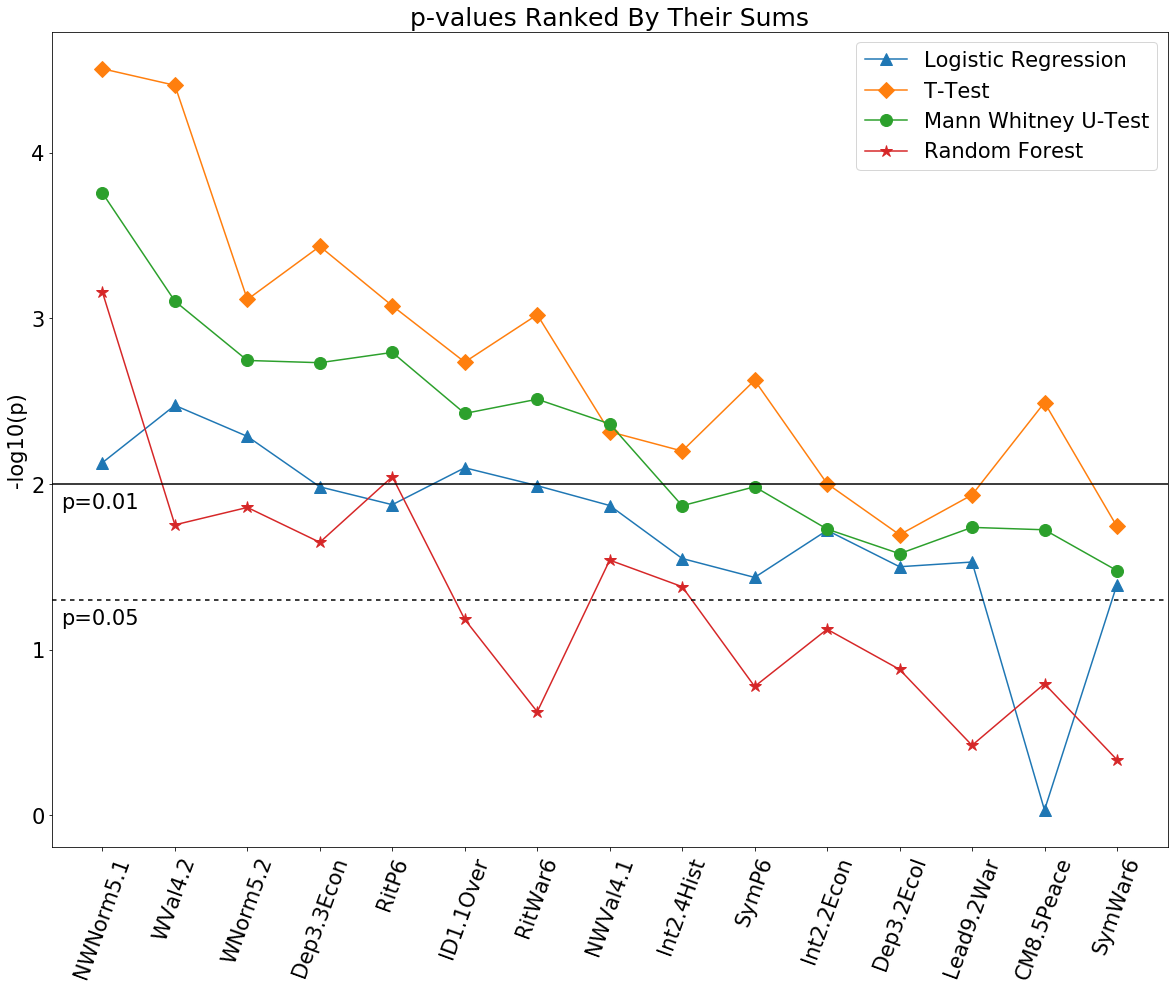

In [49]:
plt.figure()
plt.rcParams.update({'font.size': 20.95})
plt.subplots(figsize=(20,15))
plt.title('p-values Ranked By Their Sums')

for col in methods_srted_logsum[log_columns].columns:
        plt.plot(methods_srted_logsum[col], marker=next(marker), markersize=12)
    
plt.axhline(np.log10(1/0.01), 0, color='black', label='0.5')
plt.text(.5, 1.85, "p=0.01", color='black', horizontalalignment='right')
plt.axhline(np.log10(1/0.05), 0, color='black', label='0.5', dashes=(3,3))
plt.text(.5, 1.15, "p=0.05", color='black', horizontalalignment='right')

plt.xticks(range(X.shape[1]), methods_srted_logsum.index.values, rotation=70)
plt.ylabel('-log10(p)')
plt.legend(methods_names)

plt.savefig('sum.png')
plt.show()

<Figure size 432x288 with 0 Axes>

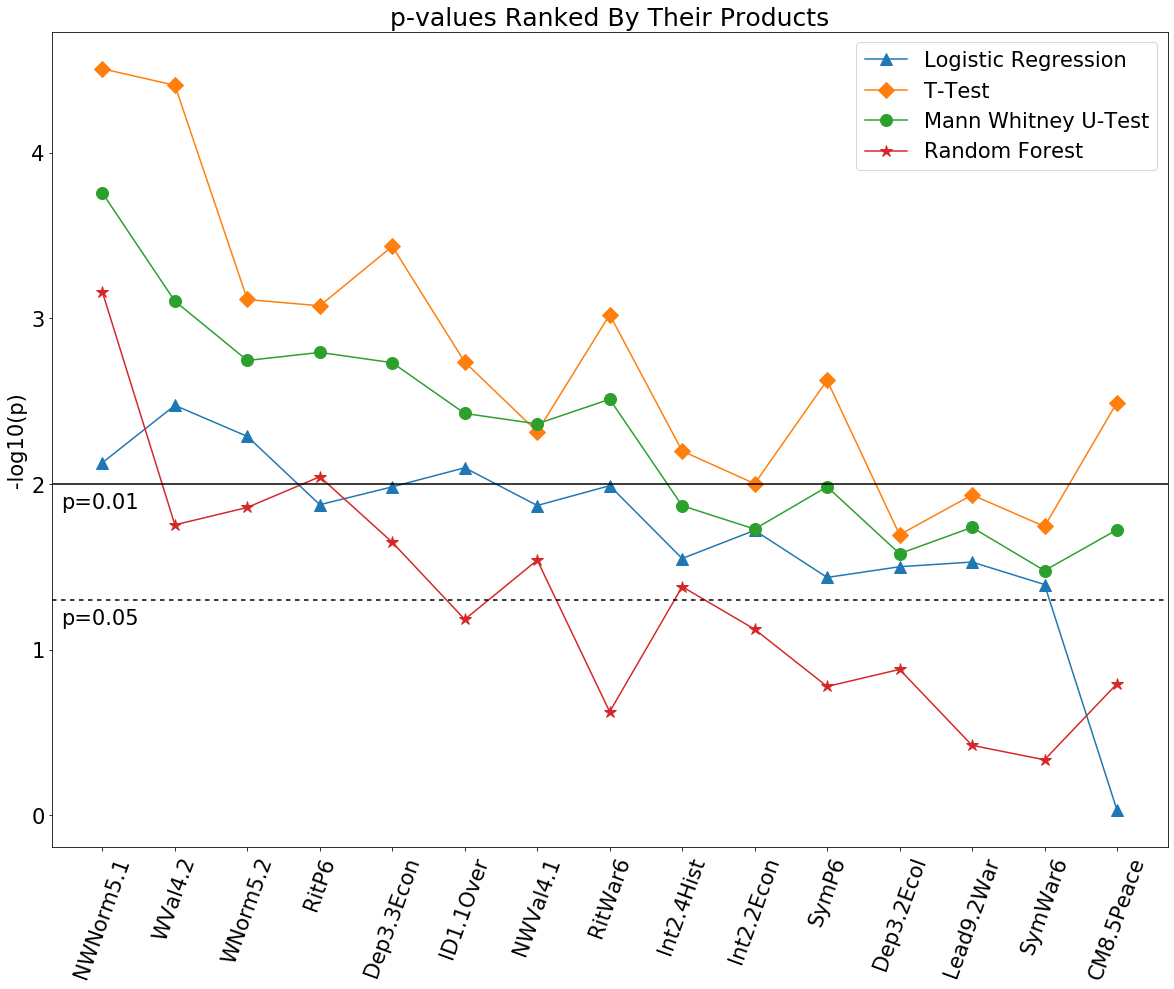

In [50]:
plt.figure()
plt.rcParams.update({'font.size': 20.95})
plt.subplots(figsize=(20,15))
plt.title('p-values Ranked By Their Products')

for col in methods_srted_logproduct[log_columns].columns:
        plt.plot(methods_srted_logproduct[col], marker=next(marker), markersize=12)
 
plt.axhline(np.log10(1/0.01), 0, color='black', label='0.5')
plt.text(.5, 1.85, "p=0.01", color='black', horizontalalignment='right')
plt.axhline(np.log10(1/0.05), 0, color='black', label='0.5', dashes=(3,3))
plt.text(.5, 1.15, "p=0.05", color='black', horizontalalignment='right')

plt.xticks(range(X.shape[1]), methods_srted_logproduct.index.values, rotation=70)
plt.ylabel('-log10(p)')
plt.legend(methods_names)

plt.savefig('product.png')
plt.show()